In [1]:
import os
os.chdir('/home/jennifer.badolato/watttime-python-client-aer-algo/')

In [2]:
import numpy as np
import pandas as pd
import datetime
import random
import pytz
from datetime import datetime, timedelta
import random
from watttime import WattTimeMyAccess, WattTimeHistorical, WattTimeForecast, WattTimeMaps
import os
import optimizer.dataset as od
from evaluation.config import MOER_REGION_LIST
import evaluation.eval_framework as evu
import optimizer.s3 as s3u

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

start = '2024-02-15 00:00Z'
end = '2024-02-20 00:00Z'

distinct_date_list = [ pd.Timestamp(date).replace(tzinfo=pytz.UTC) for date in pd.date_range(start,end,freq='d', tz=pytz.UTC).values]

In [5]:
start = "2024-02-01 00:00Z"
end = "2024-02-15 00:00Z"

distinct_date_list = [
    pd.Timestamp(date).replace(tzinfo=pytz.UTC)
    for date in pd.date_range(start, end, freq="d", tz=pytz.UTC).values
]

In [18]:
dfs = evu.execute_synth_data_process(distinct_date_list = distinct_date_list, number_of_users=1000)

  2%|██▋                                                                                                                             | 21/1000 [00:00<00:09, 101.96it/s]

working on user with 118 total_capacity, 41.170669266656816 rate of charge, and (7.687222222222222,2.1569444444444446) charging behavior.
working on user with 94 total_capacity, 55.9612747978399 rate of charge, and (7.826944444444444,2.0861111111111112) charging behavior.
working on user with 42 total_capacity, 60.10518407212623 rate of charge, and (6.147777777777778,2.0233333333333334) charging behavior.
working on user with 68 total_capacity, 17.448242168911673 rate of charge, and (8.1425,1.8983333333333334) charging behavior.
working on user with 105 total_capacity, 41.05825793544149 rate of charge, and (5.751666666666667,2.1675) charging behavior.
working on user with 121 total_capacity, 39.75769492113519 rate of charge, and (5.724722222222222,2.168888888888889) charging behavior.
working on user with 42 total_capacity, 25.955578207696533 rate of charge, and (7.476944444444444,1.9791666666666667) charging behavior.
working on user with 35 total_capacity, 12.225665968371871 rate of 

  4%|█████▌                                                                                                                          | 43/1000 [00:00<00:09, 105.26it/s]

working on user with 60 total_capacity, 19.04432132963989 rate of charge, and (7.4175,2.187222222222222) charging behavior.
working on user with 81 total_capacity, 18.45687132540471 rate of charge, and (7.088055555555556,2.132222222222222) charging behavior.
working on user with 119 total_capacity, 49.74843122844705 rate of charge, and (6.013055555555556,2.1083333333333334) charging behavior.
working on user with 81 total_capacity, 15.552517316314166 rate of charge, and (5.959444444444444,1.9891666666666667) charging behavior.
working on user with 99 total_capacity, 18.823337886546145 rate of charge, and (5.581944444444445,2.1416666666666666) charging behavior.
working on user with 90 total_capacity, 14.762679945098792 rate of charge, and (6.333611111111111,2.137777777777778) charging behavior.
working on user with 46 total_capacity, 10.74176222964146 rate of charge, and (7.9325,2.145) charging behavior.
working on user with 104 total_capacity, 15.153518922612356 rate of charge, and (6

  6%|████████▎                                                                                                                       | 65/1000 [00:00<00:08, 106.89it/s]

working on user with 85 total_capacity, 43.03388918773535 rate of charge, and (7.3925,1.9480555555555557) charging behavior.
working on user with 103 total_capacity, 38.1890741058983 rate of charge, and (5.765,2.118611111111111) charging behavior.
working on user with 82 total_capacity, 17.623075750647768 rate of charge, and (5.811388888888889,2.1769444444444446) charging behavior.
working on user with 40 total_capacity, 29.67675271576011 rate of charge, and (6.5697222222222225,2.022777777777778) charging behavior.
working on user with 92 total_capacity, 40.066948228039216 rate of charge, and (6.771388888888889,2.1977777777777776) charging behavior.
working on user with 68 total_capacity, 75.72602324788913 rate of charge, and (5.591388888888889,2.1775) charging behavior.
working on user with 79 total_capacity, 26.048175043736293 rate of charge, and (5.616388888888889,2.0458333333333334) charging behavior.
working on user with 52 total_capacity, 19.065826052678364 rate of charge, and (6

 10%|████████████▌                                                                                                                   | 98/1000 [00:00<00:08, 106.93it/s]

working on user with 41 total_capacity, 50.20034501328027 rate of charge, and (7.5825,2.206111111111111) charging behavior.
working on user with 103 total_capacity, 42.43827160493827 rate of charge, and (6.886666666666667,2.0302777777777776) charging behavior.
working on user with 103 total_capacity, 50.352352027025475 rate of charge, and (6.8180555555555555,2.1661111111111113) charging behavior.
working on user with 90 total_capacity, 31.28119232530165 rate of charge, and (7.923611111111111,2.1530555555555555) charging behavior.
working on user with 87 total_capacity, 22.904784809546715 rate of charge, and (7.643055555555556,2.0519444444444446) charging behavior.
working on user with 46 total_capacity, 18.585446590700748 rate of charge, and (6.119722222222222,1.9288888888888889) charging behavior.
working on user with 113 total_capacity, 17.01690552214054 rate of charge, and (6.714722222222222,2.1486111111111112) charging behavior.
working on user with 81 total_capacity, 38.5753762852

 12%|███████████████▎                                                                                                               | 121/1000 [00:01<00:08, 108.18it/s]

working on user with 49 total_capacity, 34.46109890178743 rate of charge, and (6.283888888888889,2.075277777777778) charging behavior.
working on user with 31 total_capacity, 15.739108536892472 rate of charge, and (5.783333333333333,2.1325) charging behavior.
working on user with 70 total_capacity, 29.369046093382888 rate of charge, and (7.170555555555556,1.8975) charging behavior.
working on user with 75 total_capacity, 17.714963024040813 rate of charge, and (7.020555555555555,2.0947222222222224) charging behavior.
working on user with 98 total_capacity, 13.886282604616254 rate of charge, and (5.888333333333334,2.0683333333333334) charging behavior.
working on user with 104 total_capacity, 14.36734693877551 rate of charge, and (6.73,2.1480555555555556) charging behavior.
working on user with 58 total_capacity, 57.232049947970864 rate of charge, and (5.996388888888889,2.0975) charging behavior.
working on user with 87 total_capacity, 61.31532520812373 rate of charge, and (7.51361111111

 14%|██████████████████▏                                                                                                            | 143/1000 [00:01<00:07, 108.89it/s]

working on user with 121 total_capacity, 14.803968540221037 rate of charge, and (6.455277777777778,1.9533333333333334) charging behavior.
working on user with 121 total_capacity, 84.91552834827718 rate of charge, and (6.3225,1.8919444444444444) charging behavior.
working on user with 118 total_capacity, 9.42679962700447 rate of charge, and (6.976666666666667,2.1466666666666665) charging behavior.
working on user with 66 total_capacity, 35.32842589380917 rate of charge, and (6.988333333333333,2.1969444444444446) charging behavior.
working on user with 56 total_capacity, 36.34657450056502 rate of charge, and (6.930555555555555,2.0341666666666667) charging behavior.
working on user with 53 total_capacity, 24.651296209975257 rate of charge, and (6.265555555555555,2.167777777777778) charging behavior.
working on user with 68 total_capacity, 61.11111111111112 rate of charge, and (5.815,1.9033333333333333) charging behavior.
working on user with 96 total_capacity, 27.024105502107876 rate of c

 17%|█████████████████████                                                                                                          | 166/1000 [00:01<00:07, 109.27it/s]

working on user with 94 total_capacity, 31.62937276078418 rate of charge, and (7.058611111111111,2.1980555555555554) charging behavior.
working on user with 91 total_capacity, 37.00956024231168 rate of charge, and (7.847222222222222,1.9527777777777777) charging behavior.
working on user with 71 total_capacity, 13.949760571382193 rate of charge, and (6.341666666666667,1.8972222222222221) charging behavior.
working on user with 81 total_capacity, 10.339296592503173 rate of charge, and (8.322222222222223,1.918611111111111) charging behavior.
working on user with 31 total_capacity, 16.988062442607898 rate of charge, and (6.174722222222222,1.9441666666666666) charging behavior.
working on user with 122 total_capacity, 22.856366270180786 rate of charge, and (6.039166666666667,2.147222222222222) charging behavior.
working on user with 104 total_capacity, 37.49429064210677 rate of charge, and (7.247222222222222,2.136388888888889) charging behavior.
working on user with 95 total_capacity, 17.62

 19%|███████████████████████▉                                                                                                       | 188/1000 [00:01<00:07, 109.34it/s]

working on user with 32 total_capacity, 19.313030292749 rate of charge, and (7.4991666666666665,2.0308333333333333) charging behavior.
working on user with 35 total_capacity, 21.759729071591487 rate of charge, and (8.272222222222222,2.0025) charging behavior.
working on user with 25 total_capacity, 34.336800309655516 rate of charge, and (7.211666666666667,2.1758333333333333) charging behavior.
working on user with 85 total_capacity, 30.453957768666204 rate of charge, and (6.3875,1.928611111111111) charging behavior.
working on user with 22 total_capacity, 19.60780818572516 rate of charge, and (8.267222222222221,2.1930555555555555) charging behavior.
working on user with 44 total_capacity, 22.70775531774343 rate of charge, and (7.22,1.8925) charging behavior.
working on user with 30 total_capacity, 80.4302286046452 rate of charge, and (5.855555555555555,2.120277777777778) charging behavior.
working on user with 112 total_capacity, 47.438227880309036 rate of charge, and (7.29472222222222

 21%|██████████████████████████▋                                                                                                    | 210/1000 [00:01<00:07, 109.39it/s]

working on user with 62 total_capacity, 29.745808545159544 rate of charge, and (6.78,2.0213888888888887) charging behavior.
working on user with 32 total_capacity, 16.43564224493105 rate of charge, and (5.773611111111111,2.15) charging behavior.
working on user with 57 total_capacity, 27.774270925388205 rate of charge, and (8.017222222222221,2.0775) charging behavior.
working on user with 119 total_capacity, 35.70124548663231 rate of charge, and (6.524166666666667,1.9633333333333334) charging behavior.
working on user with 35 total_capacity, 39.637854150713935 rate of charge, and (8.19138888888889,2.1805555555555554) charging behavior.
working on user with 43 total_capacity, 59.906980797089616 rate of charge, and (7.6322222222222225,2.1866666666666665) charging behavior.
working on user with 73 total_capacity, 22.45990603260936 rate of charge, and (7.485277777777778,2.035833333333333) charging behavior.
working on user with 62 total_capacity, 24.28636717896182 rate of charge, and (6.20

 23%|█████████████████████████████▍                                                                                                 | 232/1000 [00:02<00:07, 108.39it/s]

working on user with 95 total_capacity, 41.283542878588854 rate of charge, and (7.220277777777778,2.0252777777777777) charging behavior.
working on user with 85 total_capacity, 23.09930202649553 rate of charge, and (6.702222222222222,2.1127777777777776) charging behavior.
working on user with 103 total_capacity, 23.037565892674266 rate of charge, and (7.699722222222222,1.8913888888888888) charging behavior.
working on user with 110 total_capacity, 58.93051824033473 rate of charge, and (5.6738888888888885,2.1375) charging behavior.
working on user with 28 total_capacity, 15.276126304663762 rate of charge, and (5.583055555555555,2.0597222222222222) charging behavior.
working on user with 107 total_capacity, 14.156474961213174 rate of charge, and (5.938055555555556,2.0858333333333334) charging behavior.
working on user with 47 total_capacity, 11.140803191689566 rate of charge, and (6.512777777777778,2.218611111111111) charging behavior.
working on user with 84 total_capacity, 17.987846756

 25%|████████████████████████████████▎                                                                                              | 254/1000 [00:02<00:06, 107.90it/s]

working on user with 56 total_capacity, 42.6250852501705 rate of charge, and (8.276666666666667,2.1352777777777776) charging behavior.
working on user with 47 total_capacity, 29.6 rate of charge, and (7.535,2.161111111111111) charging behavior.
working on user with 70 total_capacity, 27.157557874957796 rate of charge, and (6.960555555555556,2.0830555555555557) charging behavior.
working on user with 104 total_capacity, 25.876020926643832 rate of charge, and (7.801388888888889,1.9055555555555554) charging behavior.
working on user with 52 total_capacity, 46.208779668136955 rate of charge, and (6.2380555555555555,1.9144444444444444) charging behavior.
working on user with 53 total_capacity, 19.188831063087175 rate of charge, and (7.614722222222222,1.9358333333333333) charging behavior.
working on user with 100 total_capacity, 17.317134990215816 rate of charge, and (7.018611111111111,1.9869444444444444) charging behavior.
working on user with 90 total_capacity, 16.733563231386736 rate of 

 28%|███████████████████████████████████                                                                                            | 276/1000 [00:02<00:06, 108.34it/s]

working on user with 36 total_capacity, 42.79414653882888 rate of charge, and (7.745277777777778,1.9219444444444445) charging behavior.
working on user with 78 total_capacity, 17.01690552214054 rate of charge, and (7.642222222222222,2.15) charging behavior.
working on user with 107 total_capacity, 27.98063739891995 rate of charge, and (7.808333333333334,2.0027777777777778) charging behavior.
working on user with 61 total_capacity, 28.344634682752673 rate of charge, and (5.9944444444444445,2.1883333333333335) charging behavior.
working on user with 85 total_capacity, 21.577258354322122 rate of charge, and (6.477777777777778,1.9505555555555556) charging behavior.
working on user with 41 total_capacity, 27.792800913406648 rate of charge, and (6.204722222222222,2.2075) charging behavior.
working on user with 91 total_capacity, 38.59479847375115 rate of charge, and (7.716944444444445,1.9775) charging behavior.
working on user with 65 total_capacity, 40.524460195769976 rate of charge, and (7

 30%|█████████████████████████████████████▉                                                                                         | 299/1000 [00:02<00:06, 108.83it/s]

working on user with 119 total_capacity, 63.8478795248557 rate of charge, and (7.823888888888889,2.0394444444444444) charging behavior.
working on user with 29 total_capacity, 12.352355961514066 rate of charge, and (5.993333333333333,2.2130555555555556) charging behavior.
working on user with 96 total_capacity, 35.7923781757601 rate of charge, and (8.046388888888888,2.138611111111111) charging behavior.
working on user with 101 total_capacity, 34.336800309655516 rate of charge, and (6.145555555555555,2.0175) charging behavior.
working on user with 83 total_capacity, 28.616024973985432 rate of charge, and (6.420555555555556,2.0236111111111112) charging behavior.
working on user with 81 total_capacity, 29.132860409899347 rate of charge, and (6.7619444444444445,2.013611111111111) charging behavior.
working on user with 117 total_capacity, 14.907552843886752 rate of charge, and (7.3133333333333335,2.1197222222222223) charging behavior.
working on user with 99 total_capacity, 22.38185255198

 33%|██████████████████████████████████████████▏                                                                                    | 332/1000 [00:03<00:06, 108.97it/s]

working on user with 93 total_capacity, 17.03965865418934 rate of charge, and (7.396388888888889,2.0908333333333333) charging behavior.
working on user with 70 total_capacity, 9.867245545071977 rate of charge, and (7.128888888888889,2.126388888888889) charging behavior.
working on user with 97 total_capacity, 13.735345870858051 rate of charge, and (6.790555555555556,1.9997222222222222) charging behavior.
working on user with 86 total_capacity, 9.62127289440393 rate of charge, and (7.483055555555556,2.0902777777777777) charging behavior.
working on user with 113 total_capacity, 15.552517316314166 rate of charge, and (5.739444444444445,2.105) charging behavior.
working on user with 56 total_capacity, 28.250328731097962 rate of charge, and (7.603611111111111,2.0108333333333333) charging behavior.
working on user with 35 total_capacity, 11.5625 rate of charge, and (7.546666666666667,1.9155555555555555) charging behavior.
working on user with 86 total_capacity, 54.04821100421575 rate of cha

 36%|█████████████████████████████████████████████                                                                                  | 355/1000 [00:03<00:05, 109.26it/s]

working on user with 36 total_capacity, 11.168192986374807 rate of charge, and (7.0761111111111115,2.1680555555555556) charging behavior.
working on user with 96 total_capacity, 25.190288803257033 rate of charge, and (7.203055555555555,1.9691666666666667) charging behavior.
working on user with 31 total_capacity, 42.79414653882888 rate of charge, and (7.743888888888889,2.02) charging behavior.
working on user with 112 total_capacity, 32.95934464837623 rate of charge, and (7.956111111111111,2.111388888888889) charging behavior.
working on user with 89 total_capacity, 26.03550295857988 rate of charge, and (7.4944444444444445,2.071388888888889) charging behavior.
working on user with 79 total_capacity, 21.697316569712896 rate of charge, and (5.603888888888889,1.9869444444444444) charging behavior.
working on user with 22 total_capacity, 70.40428058025927 rate of charge, and (7.638333333333334,2.0838888888888887) charging behavior.
working on user with 69 total_capacity, 11.195683912558685

 38%|███████████████████████████████████████████████▉                                                                               | 377/1000 [00:03<00:05, 109.27it/s]

working on user with 76 total_capacity, 33.61442119786518 rate of charge, and (7.14,1.9127777777777777) charging behavior.
working on user with 43 total_capacity, 19.313030292749 rate of charge, and (7.276111111111111,2.1147222222222224) charging behavior.
working on user with 22 total_capacity, 33.73808815455725 rate of charge, and (6.875,2.143611111111111) charging behavior.
working on user with 102 total_capacity, 42.43827160493827 rate of charge, and (6.74,1.9605555555555556) charging behavior.
working on user with 66 total_capacity, 27.194335667101775 rate of charge, and (6.7572222222222225,2.0725) charging behavior.
working on user with 85 total_capacity, 38.00389712690537 rate of charge, and (6.135833333333333,2.071388888888889) charging behavior.
working on user with 63 total_capacity, 34.63426998043163 rate of charge, and (7.432777777777778,2.1980555555555554) charging behavior.
working on user with 121 total_capacity, 67.24045185583648 rate of charge, and (7.508055555555556,2

 39%|█████████████████████████████████████████████████▋                                                                              | 388/1000 [00:03<00:06, 90.69it/s]

working on user with 25 total_capacity, 34.95159204501764 rate of charge, and (8.312777777777777,2.0530555555555554) charging behavior.
working on user with 25 total_capacity, 29.6 rate of charge, and (6.079444444444444,2.0605555555555557) charging behavior.
working on user with 67 total_capacity, 13.732405355638088 rate of charge, and (6.002777777777778,2.2127777777777777) charging behavior.
working on user with 82 total_capacity, 32.245015213784455 rate of charge, and (6.024166666666667,1.9283333333333332) charging behavior.
working on user with 74 total_capacity, 14.838376357880055 rate of charge, and (5.990277777777778,1.9416666666666667) charging behavior.
working on user with 82 total_capacity, 13.550110689755567 rate of charge, and (7.530833333333334,2.147222222222222) charging behavior.
working on user with 76 total_capacity, 54.56010912021824 rate of charge, and (7.188888888888889,2.036111111111111) charging behavior.
working on user with 96 total_capacity, 22.97103144107722 r

 41%|████████████████████████████████████████████████████▍                                                                           | 410/1000 [00:03<00:05, 99.07it/s]

working on user with 100 total_capacity, 14.156474961213174 rate of charge, and (6.535833333333334,1.905) charging behavior.
working on user with 41 total_capacity, 16.3992837985512 rate of charge, and (7.413333333333333,2.1222222222222222) charging behavior.
working on user with 34 total_capacity, 38.4313040440213 rate of charge, and (5.69,2.1955555555555555) charging behavior.
working on user with 49 total_capacity, 22.61724289696318 rate of charge, and (5.7972222222222225,2.2105555555555556) charging behavior.
working on user with 61 total_capacity, 21.40311907075756 rate of charge, and (7.394722222222223,2.1958333333333333) charging behavior.
working on user with 120 total_capacity, 9.300408212511813 rate of charge, and (8.006666666666666,2.0502777777777776) charging behavior.
working on user with 120 total_capacity, 14.769680263276264 rate of charge, and (7.326666666666667,2.013611111111111) charging behavior.
working on user with 110 total_capacity, 45.677648680746465 rate of cha

 43%|██████████████████████████████████████████████████████▊                                                                        | 432/1000 [00:04<00:05, 103.15it/s]

working on user with 80 total_capacity, 36.44019088034532 rate of charge, and (8.011111111111111,2.138611111111111) charging behavior.
working on user with 103 total_capacity, 38.00389712690537 rate of charge, and (8.31611111111111,1.9702777777777778) charging behavior.
working on user with 75 total_capacity, 24.72526855013273 rate of charge, and (8.033888888888889,2.0297222222222224) charging behavior.
working on user with 106 total_capacity, 17.580843912472968 rate of charge, and (6.6466666666666665,2.1702777777777778) charging behavior.
working on user with 80 total_capacity, 83.92333984375 rate of charge, and (8.015,1.968611111111111) charging behavior.
working on user with 74 total_capacity, 18.944482333409113 rate of charge, and (5.650833333333333,2.0791666666666666) charging behavior.
working on user with 106 total_capacity, 9.731924922144602 rate of charge, and (6.8180555555555555,1.9908333333333332) charging behavior.
working on user with 77 total_capacity, 13.404607199723214 

 46%|█████████████████████████████████████████████████████████▊                                                                     | 455/1000 [00:04<00:05, 106.26it/s]

working on user with 92 total_capacity, 15.72474054178106 rate of charge, and (6.964444444444444,1.9752777777777777) charging behavior.
working on user with 112 total_capacity, 14.076288364284105 rate of charge, and (7.515,1.9605555555555556) charging behavior.
working on user with 120 total_capacity, 13.513513513513514 rate of charge, and (6.105,2.0297222222222224) charging behavior.
working on user with 23 total_capacity, 58.16643532288982 rate of charge, and (6.176111111111111,2.203888888888889) charging behavior.
working on user with 33 total_capacity, 25.005406574394463 rate of charge, and (6.2844444444444445,2.1902777777777778) charging behavior.
working on user with 109 total_capacity, 10.9518650730223 rate of charge, and (7.121388888888889,1.9341666666666666) charging behavior.
working on user with 40 total_capacity, 70.40428058025927 rate of charge, and (8.030833333333334,2.2180555555555554) charging behavior.
working on user with 45 total_capacity, 15.890809911242606 rate of 

 48%|████████████████████████████████████████████████████████████▌                                                                  | 477/1000 [00:04<00:04, 107.82it/s]

working on user with 27 total_capacity, 33.270321361058606 rate of charge, and (5.658611111111111,2.151388888888889) charging behavior.
working on user with 37 total_capacity, 31.105034632628332 rate of charge, and (7.976666666666667,1.9361111111111111) charging behavior.
working on user with 76 total_capacity, 21.33050463938476 rate of charge, and (7.051111111111111,2.1933333333333334) charging behavior.
working on user with 66 total_capacity, 45.41551063548686 rate of charge, and (6.687777777777778,1.958611111111111) charging behavior.
working on user with 99 total_capacity, 43.82452659551157 rate of charge, and (5.9425,2.1597222222222223) charging behavior.
working on user with 65 total_capacity, 39.0124875426034 rate of charge, and (6.716388888888889,1.9197222222222223) charging behavior.
working on user with 96 total_capacity, 29.539360526552528 rate of charge, and (6.908888888888889,2.182777777777778) charging behavior.
working on user with 95 total_capacity, 24.651296209975257 r

 50%|███████████████████████████████████████████████████████████████▎                                                               | 499/1000 [00:04<00:04, 108.55it/s]

working on user with 61 total_capacity, 50.352352027025475 rate of charge, and (6.492222222222222,1.905) charging behavior.
working on user with 40 total_capacity, 19.246381680244113 rate of charge, and (8.327777777777778,2.1894444444444443) charging behavior.
working on user with 122 total_capacity, 25.796828866182466 rate of charge, and (6.570833333333334,2.02) charging behavior.
working on user with 64 total_capacity, 30.657662604061866 rate of charge, and (8.134166666666667,2.2127777777777777) charging behavior.
working on user with 67 total_capacity, 14.803968540221037 rate of charge, and (5.618055555555555,2.0347222222222223) charging behavior.
working on user with 61 total_capacity, 43.397298320919084 rate of charge, and (6.858055555555556,2.1483333333333334) charging behavior.
working on user with 83 total_capacity, 55.60596601464459 rate of charge, and (6.416111111111111,1.9391666666666667) charging behavior.
working on user with 104 total_capacity, 16.240261379624968 rate of 

 53%|███████████████████████████████████████████████████████████████████▌                                                           | 532/1000 [00:04<00:04, 108.96it/s]

working on user with 25 total_capacity, 30.052592036063114 rate of charge, and (7.031666666666666,1.9569444444444444) charging behavior.
working on user with 39 total_capacity, 18.747145321053384 rate of charge, and (6.4944444444444445,1.9969444444444444) charging behavior.
working on user with 102 total_capacity, 19.501602293810087 rate of charge, and (8.188611111111111,1.928611111111111) charging behavior.
working on user with 98 total_capacity, 14.172317341376337 rate of charge, and (8.195555555555556,1.9372222222222222) charging behavior.
working on user with 95 total_capacity, 62.5623846506033 rate of charge, and (6.946666666666666,1.8952777777777778) charging behavior.
working on user with 44 total_capacity, 10.978560651355037 rate of charge, and (6.086388888888889,1.9377777777777778) charging behavior.
working on user with 52 total_capacity, 16.04471516254755 rate of charge, and (6.845,2.0383333333333336) charging behavior.
working on user with 63 total_capacity, 19.065826052678

 55%|██████████████████████████████████████████████████████████████████████▎                                                        | 554/1000 [00:05<00:04, 106.52it/s]

working on user with 31 total_capacity, 12.194298012164635 rate of charge, and (5.8625,2.180277777777778) charging behavior.
working on user with 62 total_capacity, 28.902185630145762 rate of charge, and (7.4880555555555555,2.0680555555555555) charging behavior.
working on user with 76 total_capacity, 13.671236588206197 rate of charge, and (6.221111111111111,1.903888888888889) charging behavior.
working on user with 121 total_capacity, 21.27820087008498 rate of charge, and (7.658611111111111,2.1505555555555556) charging behavior.
working on user with 76 total_capacity, 21.921963733962162 rate of charge, and (6.0008333333333335,2.1555555555555554) charging behavior.
working on user with 115 total_capacity, 61.11111111111112 rate of charge, and (6.8838888888888885,2.1094444444444442) charging behavior.
working on user with 28 total_capacity, 30.760282323463947 rate of charge, and (7.013055555555556,2.0344444444444445) charging behavior.
working on user with 35 total_capacity, 12.10091509

 58%|█████████████████████████████████████████████████████████████████████████▏                                                     | 576/1000 [00:05<00:03, 107.96it/s]

working on user with 89 total_capacity, 41.313622979388256 rate of charge, and (6.521388888888889,2.0502777777777776) charging behavior.
working on user with 48 total_capacity, 16.05063324086144 rate of charge, and (7.559444444444445,2.0213888888888887) charging behavior.
working on user with 80 total_capacity, 27.685389222901055 rate of charge, and (7.335833333333333,1.8977777777777778) charging behavior.
working on user with 33 total_capacity, 53.543483393001864 rate of charge, and (6.1425,1.9394444444444445) charging behavior.
working on user with 109 total_capacity, 23.85904941209133 rate of charge, and (6.347222222222222,1.9297222222222221) charging behavior.
working on user with 120 total_capacity, 22.44897959183674 rate of charge, and (7.235,2.1883333333333335) charging behavior.
working on user with 113 total_capacity, 15.232323814503234 rate of charge, and (8.200555555555555,2.185277777777778) charging behavior.
working on user with 60 total_capacity, 13.640805353148048 rate o

 60%|████████████████████████████████████████████████████████████████████████████                                                   | 599/1000 [00:05<00:03, 108.59it/s]

working on user with 106 total_capacity, 19.313030292749 rate of charge, and (8.061111111111112,2.098888888888889) charging behavior.
working on user with 106 total_capacity, 9.959033381603245 rate of charge, and (5.722777777777778,2.077777777777778) charging behavior.
working on user with 74 total_capacity, 27.774270925388205 rate of charge, and (7.732222222222222,1.9819444444444445) charging behavior.
working on user with 91 total_capacity, 22.70775531774343 rate of charge, and (5.934444444444445,2.1847222222222222) charging behavior.
working on user with 70 total_capacity, 33.448833167862965 rate of charge, and (6.0552777777777775,2.1197222222222223) charging behavior.
working on user with 50 total_capacity, 27.024105502107876 rate of charge, and (8.05861111111111,2.2108333333333334) charging behavior.
working on user with 34 total_capacity, 46.74922863772747 rate of charge, and (7.054166666666666,2.1347222222222224) charging behavior.
working on user with 65 total_capacity, 19.7658

 62%|██████████████████████████████████████████████████████████████████████████████▊                                                | 621/1000 [00:05<00:03, 108.72it/s]

working on user with 46 total_capacity, 16.68335001668335 rate of charge, and (7.266666666666667,2.0525) charging behavior.
working on user with 35 total_capacity, 23.766395601289805 rate of charge, and (8.102777777777778,1.9122222222222223) charging behavior.
working on user with 46 total_capacity, 44.389204545454554 rate of charge, and (8.214722222222223,2.1577777777777776) charging behavior.
working on user with 90 total_capacity, 15.72474054178106 rate of charge, and (6.926111111111111,2.0519444444444446) charging behavior.
working on user with 88 total_capacity, 21.846695244505856 rate of charge, and (6.232777777777778,2.1830555555555557) charging behavior.
working on user with 65 total_capacity, 16.64223284299264 rate of charge, and (5.8661111111111115,2.0661111111111112) charging behavior.
working on user with 50 total_capacity, 16.784003483814775 rate of charge, and (6.770555555555555,2.0030555555555556) charging behavior.
working on user with 89 total_capacity, 11.827113177481

 64%|█████████████████████████████████████████████████████████████████████████████████▋                                             | 643/1000 [00:06<00:03, 108.65it/s]

working on user with 121 total_capacity, 62.14250406044772 rate of charge, and (6.579722222222222,2.1844444444444444) charging behavior.
working on user with 59 total_capacity, 10.09913529565901 rate of charge, and (5.5675,2.1294444444444443) charging behavior.
working on user with 91 total_capacity, 11.649708993417914 rate of charge, and (7.6241666666666665,1.9013888888888888) charging behavior.
working on user with 99 total_capacity, 36.16042077580539 rate of charge, and (8.135277777777778,1.9208333333333334) charging behavior.
working on user with 47 total_capacity, 18.236977196385137 rate of charge, and (5.788611111111111,1.9480555555555557) charging behavior.
working on user with 45 total_capacity, 37.00956024231168 rate of charge, and (5.609166666666667,2.0608333333333335) charging behavior.
working on user with 90 total_capacity, 13.735345870858051 rate of charge, and (7.5325,1.9738888888888888) charging behavior.
working on user with 25 total_capacity, 24.822552295079767 rate o

 66%|████████████████████████████████████████████████████████████████████████████████████▍                                          | 665/1000 [00:06<00:03, 108.34it/s]

working on user with 99 total_capacity, 19.375582576638287 rate of charge, and (6.6563888888888885,1.9147222222222222) charging behavior.
working on user with 33 total_capacity, 25.955578207696533 rate of charge, and (6.243333333333333,1.9244444444444444) charging behavior.
working on user with 89 total_capacity, 9.135802469135804 rate of charge, and (6.958888888888889,1.9394444444444445) charging behavior.
working on user with 107 total_capacity, 37.789713983396574 rate of charge, and (8.329722222222221,2.0155555555555558) charging behavior.
working on user with 45 total_capacity, 14.23688362383047 rate of charge, and (5.854444444444445,2.036388888888889) charging behavior.
working on user with 72 total_capacity, 17.805230205439983 rate of charge, and (7.16,1.906111111111111) charging behavior.
working on user with 122 total_capacity, 27.8915980364315 rate of charge, and (7.004722222222222,2.043888888888889) charging behavior.
working on user with 120 total_capacity, 28.67505735011470

 69%|███████████████████████████████████████████████████████████████████████████████████████▏                                       | 687/1000 [00:06<00:02, 108.98it/s]

working on user with 68 total_capacity, 20.555555555555557 rate of charge, and (6.066111111111111,2.0097222222222224) charging behavior.
working on user with 105 total_capacity, 65.17340569556319 rate of charge, and (8.220555555555556,2.086388888888889) charging behavior.
working on user with 102 total_capacity, 39.0070230371932 rate of charge, and (5.622222222222222,1.9555555555555555) charging behavior.
working on user with 54 total_capacity, 10.638970837718317 rate of charge, and (5.971111111111111,1.9938888888888888) charging behavior.
working on user with 47 total_capacity, 12.352355961514066 rate of charge, and (5.6194444444444445,2.101111111111111) charging behavior.
working on user with 79 total_capacity, 73.79677709348039 rate of charge, and (8.123333333333333,2.153888888888889) charging behavior.
working on user with 40 total_capacity, 11.140803191689566 rate of charge, and (7.970277777777778,2.0194444444444444) charging behavior.
working on user with 74 total_capacity, 15.45

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 710/1000 [00:06<00:02, 108.92it/s]

working on user with 108 total_capacity, 15.145282142279695 rate of charge, and (7.990277777777778,2.07) charging behavior.
working on user with 107 total_capacity, 16.289656508378165 rate of charge, and (8.129166666666666,2.0883333333333334) charging behavior.
working on user with 33 total_capacity, 14.172317341376337 rate of charge, and (8.105277777777777,1.9402777777777778) charging behavior.
working on user with 42 total_capacity, 31.858155905126413 rate of charge, and (5.665,2.2133333333333334) charging behavior.
working on user with 87 total_capacity, 15.29681381274475 rate of charge, and (6.232777777777778,2.1219444444444444) charging behavior.
working on user with 83 total_capacity, 27.47242548104588 rate of charge, and (7.250277777777778,2.2144444444444447) charging behavior.
working on user with 31 total_capacity, 87.30020158410183 rate of charge, and (5.601666666666667,2.1261111111111113) charging behavior.
working on user with 33 total_capacity, 53.37681117225182 rate of ch

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 733/1000 [00:06<00:02, 109.14it/s]

working on user with 121 total_capacity, 27.578599007170435 rate of charge, and (7.7575,2.049166666666667) charging behavior.
working on user with 57 total_capacity, 15.04736500119695 rate of charge, and (5.627777777777778,2.0525) charging behavior.
working on user with 42 total_capacity, 9.687436180741377 rate of charge, and (6.895555555555555,2.104722222222222) charging behavior.
working on user with 43 total_capacity, 30.378306575108294 rate of charge, and (7.182777777777778,1.9872222222222222) charging behavior.
working on user with 103 total_capacity, 32.638964098623084 rate of charge, and (6.446944444444444,1.9097222222222223) charging behavior.
working on user with 123 total_capacity, 26.146192549041775 rate of charge, and (7.993333333333333,2.1591666666666667) charging behavior.
working on user with 116 total_capacity, 45.54629677552922 rate of charge, and (5.755833333333333,2.013611111111111) charging behavior.
working on user with 73 total_capacity, 82.30791390592205 rate of 

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 767/1000 [00:07<00:02, 108.53it/s]

working on user with 68 total_capacity, 34.58075549519643 rate of charge, and (8.001388888888888,2.158888888888889) charging behavior.
working on user with 22 total_capacity, 23.58040596884385 rate of charge, and (6.780555555555556,2.1569444444444446) charging behavior.
working on user with 91 total_capacity, 12.947565857618766 rate of charge, and (7.168333333333333,2.1666666666666665) charging behavior.
working on user with 103 total_capacity, 36.06787974968891 rate of charge, and (7.3133333333333335,2.2175) charging behavior.
working on user with 102 total_capacity, 53.87917839151059 rate of charge, and (6.117222222222222,2.096111111111111) charging behavior.
working on user with 24 total_capacity, 34.20376738950628 rate of charge, and (8.217222222222222,2.1166666666666667) charging behavior.
working on user with 96 total_capacity, 15.478808807160778 rate of charge, and (6.333888888888889,1.9213888888888888) charging behavior.
working on user with 50 total_capacity, 17.89821719244695

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 789/1000 [00:07<00:01, 108.56it/s]

working on user with 80 total_capacity, 29.08321766144491 rate of charge, and (6.196666666666666,2.176388888888889) charging behavior.
working on user with 64 total_capacity, 17.059315239086303 rate of charge, and (6.801388888888889,1.9808333333333332) charging behavior.
working on user with 50 total_capacity, 38.59479847375115 rate of charge, and (5.775277777777778,1.9436111111111112) charging behavior.
working on user with 100 total_capacity, 36.16042077580539 rate of charge, and (8.22,2.1416666666666666) charging behavior.
working on user with 122 total_capacity, 40.06176796223996 rate of charge, and (7.72,1.9791666666666667) charging behavior.
working on user with 37 total_capacity, 31.105034632628332 rate of charge, and (7.2588888888888885,2.1880555555555556) charging behavior.
working on user with 118 total_capacity, 69.65463963222349 rate of charge, and (6.254722222222222,1.9469444444444444) charging behavior.
working on user with 32 total_capacity, 16.241426611796978 rate of ch

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 811/1000 [00:07<00:01, 108.51it/s]

working on user with 52 total_capacity, 15.189153287554147 rate of charge, and (8.1475,2.1266666666666665) charging behavior.
working on user with 29 total_capacity, 12.91338088016906 rate of charge, and (7.363611111111111,2.0055555555555555) charging behavior.
working on user with 74 total_capacity, 22.45990603260936 rate of charge, and (6.075277777777778,2.1416666666666666) charging behavior.
working on user with 27 total_capacity, 10.613503531858441 rate of charge, and (7.0761111111111115,2.0075) charging behavior.
working on user with 76 total_capacity, 85.250170500341 rate of charge, and (7.204444444444444,1.9508333333333334) charging behavior.
working on user with 89 total_capacity, 16.97465375564214 rate of charge, and (7.740277777777778,2.0838888888888887) charging behavior.
working on user with 60 total_capacity, 28.341092781008374 rate of charge, and (6.0675,2.0225) charging behavior.
working on user with 111 total_capacity, 16.6333624791802 rate of charge, and (7.20638888888

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 833/1000 [00:07<00:01, 108.54it/s]

working on user with 119 total_capacity, 14.400242971372316 rate of charge, and (6.694166666666667,1.955) charging behavior.
working on user with 78 total_capacity, 78.91414141414141 rate of charge, and (7.955277777777778,2.0094444444444446) charging behavior.
working on user with 101 total_capacity, 31.93496879082596 rate of charge, and (6.716111111111111,2.1594444444444445) charging behavior.
working on user with 39 total_capacity, 47.1608119376877 rate of charge, and (8.127222222222223,2.1594444444444445) charging behavior.
working on user with 114 total_capacity, 10.613503531858441 rate of charge, and (6.6075,2.192222222222222) charging behavior.
working on user with 29 total_capacity, 18.703824932198636 rate of charge, and (6.5725,2.1441666666666666) charging behavior.
working on user with 122 total_capacity, 13.580246913580245 rate of charge, and (5.978888888888889,2.068888888888889) charging behavior.
working on user with 75 total_capacity, 13.261434851409208 rate of charge, and

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 855/1000 [00:07<00:01, 108.48it/s]

working on user with 30 total_capacity, 31.553659148768332 rate of charge, and (7.040277777777778,2.026111111111111) charging behavior.
working on user with 53 total_capacity, 13.440762563480359 rate of charge, and (5.663333333333333,1.948611111111111) charging behavior.
working on user with 95 total_capacity, 87.30020158410183 rate of charge, and (5.850833333333333,2.109722222222222) charging behavior.
working on user with 60 total_capacity, 37.888964666818225 rate of charge, and (8.225277777777778,2.1886111111111113) charging behavior.
working on user with 57 total_capacity, 9.279590293548553 rate of charge, and (7.4,2.077777777777778) charging behavior.
working on user with 47 total_capacity, 14.156474961213174 rate of charge, and (6.713888888888889,1.9780555555555555) charging behavior.
working on user with 38 total_capacity, 11.059235657366948 rate of charge, and (7.173611111111111,1.9619444444444445) charging behavior.
working on user with 59 total_capacity, 16.14560719483166 rat

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 877/1000 [00:08<00:01, 107.97it/s]

working on user with 54 total_capacity, 29.756752077562325 rate of charge, and (7.491666666666666,2.174166666666667) charging behavior.
working on user with 49 total_capacity, 14.638363193616094 rate of charge, and (7.716388888888889,1.9555555555555555) charging behavior.
working on user with 67 total_capacity, 12.74446993338431 rate of charge, and (5.766388888888889,1.9111111111111112) charging behavior.
working on user with 110 total_capacity, 27.220951223767354 rate of charge, and (7.605555555555555,2.0544444444444445) charging behavior.
working on user with 43 total_capacity, 22.44897959183674 rate of charge, and (7.3,2.198611111111111) charging behavior.
working on user with 76 total_capacity, 29.364613260106985 rate of charge, and (8.301388888888889,2.1908333333333334) charging behavior.
working on user with 54 total_capacity, 15.369224664531743 rate of charge, and (6.208888888888889,2.1686111111111113) charging behavior.
working on user with 55 total_capacity, 10.218157666172791

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 899/1000 [00:08<00:00, 108.21it/s]

working on user with 38 total_capacity, 31.600114909508765 rate of charge, and (6.070555555555556,2.1619444444444444) charging behavior.
working on user with 66 total_capacity, 33.20273590543861 rate of charge, and (6.146944444444444,2.1822222222222223) charging behavior.
working on user with 28 total_capacity, 16.359309934562763 rate of charge, and (7.4944444444444445,1.9336111111111112) charging behavior.
working on user with 40 total_capacity, 32.81221568960838 rate of charge, and (6.6075,2.075277777777778) charging behavior.
working on user with 42 total_capacity, 68.43157930753465 rate of charge, and (7.760277777777778,2.117777777777778) charging behavior.
working on user with 90 total_capacity, 30.236019620428007 rate of charge, and (7.1563888888888885,2.0416666666666665) charging behavior.
working on user with 60 total_capacity, 11.36278136319595 rate of charge, and (6.166388888888889,1.9358333333333333) charging behavior.
working on user with 68 total_capacity, 85.5867947356340

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 921/1000 [00:08<00:00, 91.45it/s]

working on user with 25 total_capacity, 39.42588739608143 rate of charge, and (6.716666666666667,1.9530555555555555) charging behavior.
working on user with 122 total_capacity, 79.81859410430839 rate of charge, and (6.6947222222222225,1.9666666666666666) charging behavior.
working on user with 101 total_capacity, 17.404374826945133 rate of charge, and (7.3036111111111115,2.187222222222222) charging behavior.
working on user with 114 total_capacity, 44.389204545454554 rate of charge, and (6.646111111111111,2.140833333333333) charging behavior.
working on user with 102 total_capacity, 25.100172506640135 rate of charge, and (6.078055555555555,2.143611111111111) charging behavior.
working on user with 62 total_capacity, 33.53147386069197 rate of charge, and (7.869166666666667,2.1855555555555557) charging behavior.
working on user with 49 total_capacity, 36.72322042612289 rate of charge, and (6.535277777777778,1.905) charging behavior.
working on user with 67 total_capacity, 25.853786356887

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 944/1000 [00:08<00:00, 100.18it/s]

working on user with 115 total_capacity, 25.176176013512737 rate of charge, and (7.9447222222222225,1.9172222222222222) charging behavior.
working on user with 123 total_capacity, 62.14250406044772 rate of charge, and (5.7427777777777775,2.0702777777777777) charging behavior.
working on user with 107 total_capacity, 14.8464396632667 rate of charge, and (7.138888888888889,2.084722222222222) charging behavior.
working on user with 72 total_capacity, 39.308035634521026 rate of charge, and (7.277222222222222,2.128888888888889) charging behavior.
working on user with 95 total_capacity, 18.698292845863172 rate of charge, and (7.208611111111111,1.9966666666666666) charging behavior.
working on user with 120 total_capacity, 9.258842194295553 rate of charge, and (7.303055555555556,2.174722222222222) charging behavior.
working on user with 97 total_capacity, 17.536475869809202 rate of charge, and (8.295555555555556,2.0075) charging behavior.
working on user with 107 total_capacity, 9.44811516486

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 967/1000 [00:09<00:00, 104.53it/s]

working on user with 95 total_capacity, 11.059235657366948 rate of charge, and (7.7716666666666665,2.0805555555555557) charging behavior.
working on user with 122 total_capacity, 53.7109375 rate of charge, and (8.10361111111111,1.9616666666666667) charging behavior.
working on user with 82 total_capacity, 12.611715943254096 rate of charge, and (6.164722222222222,1.9191666666666667) charging behavior.
working on user with 98 total_capacity, 34.375 rate of charge, and (7.603888888888889,2.100277777777778) charging behavior.
working on user with 74 total_capacity, 21.456883368184517 rate of charge, and (5.853611111111111,2.0319444444444446) charging behavior.
working on user with 27 total_capacity, 16.6333624791802 rate of charge, and (5.589166666666666,1.9519444444444445) charging behavior.
working on user with 66 total_capacity, 30.165250728079464 rate of charge, and (6.9275,2.1219444444444444) charging behavior.
working on user with 36 total_capacity, 56.500657462195925 rate of charge,

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 990/1000 [00:09<00:00, 106.78it/s]

working on user with 89 total_capacity, 64.06597630723714 rate of charge, and (6.428333333333334,2.013333333333333) charging behavior.
working on user with 87 total_capacity, 16.520088427527874 rate of charge, and (7.05,2.1894444444444443) charging behavior.
working on user with 66 total_capacity, 19.065826052678364 rate of charge, and (6.445277777777778,1.9875) charging behavior.
working on user with 79 total_capacity, 9.512497364781135 rate of charge, and (6.701666666666667,2.1566666666666667) charging behavior.
working on user with 97 total_capacity, 29.95442842185094 rate of charge, and (7.9863888888888885,2.203888888888889) charging behavior.
working on user with 79 total_capacity, 57.78995452981305 rate of charge, and (7.287222222222222,2.0477777777777777) charging behavior.
working on user with 119 total_capacity, 16.534059044465447 rate of charge, and (7.123055555555555,1.9202777777777778) charging behavior.
working on user with 85 total_capacity, 22.44897959183674 rate of char

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.48it/s]


working on user with 106 total_capacity, 38.57537628526139 rate of charge, and (7.601666666666667,1.9694444444444446) charging behavior.
working on user with 110 total_capacity, 43.476714267081405 rate of charge, and (7.612777777777778,2.1327777777777777) charging behavior.
working on user with 53 total_capacity, 64.72701381921746 rate of charge, and (5.663888888888889,2.1575) charging behavior.


## Distributions

In [9]:
import seaborn as sns

In [31]:
dfs.uncharged.value_counts()

uncharged
False    14799
True       201
Name: count, dtype: int64

Text(0.5, 1.0, 'length_plugged_in')

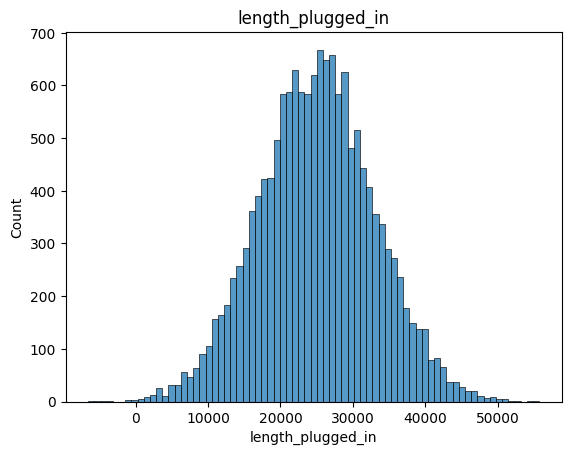

In [28]:
sns.histplot(dfs["length_plugged_in"]).set_title("length_plugged_in")

Text(0.5, 1.0, 'total_seconds_to_95')

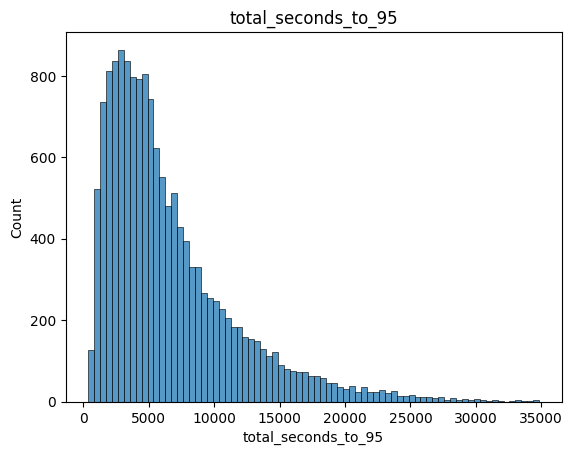

In [25]:
sns.histplot(dfs["total_seconds_to_95"]).set_title("total_seconds_to_95")

Text(0.5, 1.0, 'final_perc_charged')

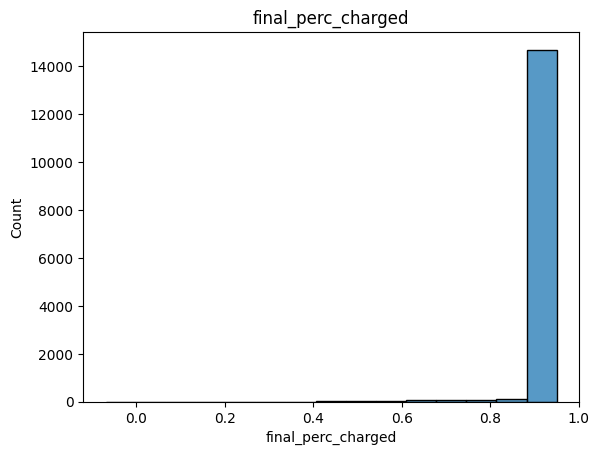

In [24]:
sns.histplot(dfs["final_perc_charged"]).set_title("final_perc_charged")

Text(0.5, 1.0, 'total_capacity')

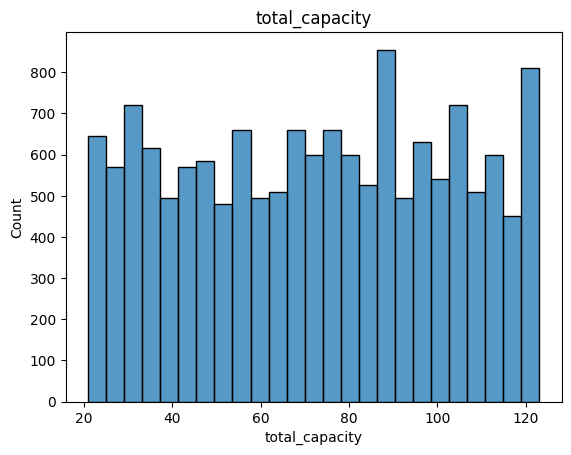

In [23]:
sns.histplot(dfs["total_capacity"]).set_title("total_capacity")

Text(0.5, 1.0, 'power_output_max_rate')

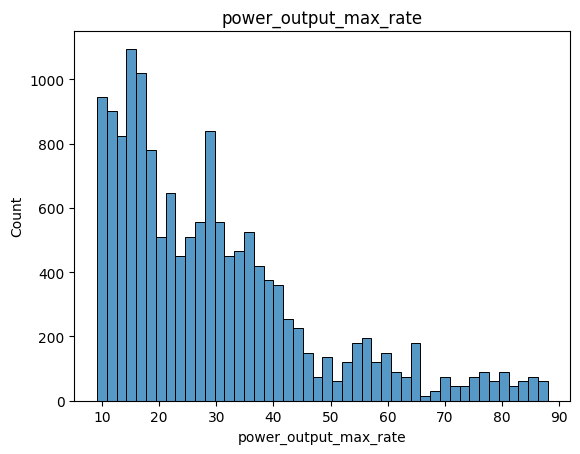

In [22]:
sns.histplot(dfs["power_output_max_rate"]).set_title("power_output_max_rate")

## Add interaction w/ MOER

In [17]:
df["shifted_plug_in_time"] = df["plug_in_time"].dt.tz_convert(tz = 'US/Eastern')

In [18]:
df[["shifted_plug_in_time","plug_in_time"]].head()

,shifted_plug_in_time,plug_in_time
0,2024-02-01 15:42:02-05:00,2024-02-01 20:42:02+00:00
1,2024-02-02 13:54:40-05:00,2024-02-02 18:54:40+00:00
2,2024-02-03 15:35:20-05:00,2024-02-03 20:35:20+00:00
3,2024-02-04 14:13:16-05:00,2024-02-04 19:13:16+00:00
4,2024-02-05 15:42:23-05:00,2024-02-05 20:42:23+00:00


In [91]:
dfs.head()

,index,distinct_dates,user_type,plug_in_time,unplug_time,initial_charge,total_seconds_to_95,full_charge_time,length_plugged_in,session_charge,final_perc_charged,uncharged,total_capacity,power_output_max_rate
0,0,2024-02-01 00:00:00+00:00,r22.0_tc31_avglc20247_sdlc7211,2024-02-01 19:25:29+00:00,2024-02-02 00:41:34.888669+00:00,0.218159,3712.428845,2024-02-01 20:27:21.428845191+00:00,18965.888669,22.687065,0.95,False,31,22.0
1,1,2024-02-02 00:00:00+00:00,r22.0_tc31_avglc20247_sdlc7211,2024-02-02 19:25:12+00:00,2024-02-03 03:35:39.211227+00:00,0.585172,1850.671641,2024-02-02 19:56:02.671640646+00:00,29427.211227,11.309660,0.95,False,31,22.0
2,2,2024-02-03 00:00:00+00:00,r22.0_tc31_avglc20247_sdlc7211,2024-02-03 20:34:36+00:00,2024-02-04 02:03:28.134960+00:00,0.209559,3756.055708,2024-02-03 21:37:12.055708431+00:00,19732.134960,22.953674,0.95,False,31,22.0
3,3,2024-02-04 00:00:00+00:00,r22.0_tc31_avglc20247_sdlc7211,2024-02-04 19:19:29+00:00,2024-02-05 01:59:05.771913+00:00,0.530715,2126.920051,2024-02-04 19:54:55.920050508+00:00,23976.771913,12.997845,0.95,False,31,22.0
4,4,2024-02-05 00:00:00+00:00,r22.0_tc31_avglc20247_sdlc7211,2024-02-05 19:51:36+00:00,2024-02-06 05:58:25.936832+00:00,0.499819,2283.646637,2024-02-05 20:29:39.646636713+00:00,36409.936832,13.955618,0.95,False,31,22.0


In [90]:
dfs["final_perc_charged"].describe()

count    140.000000
mean       0.940043
std        0.048787
min        0.570739
25%        0.950000
50%        0.950000
75%        0.950000
max        0.950000
Name: final_perc_charged, dtype: float64

In [77]:
.95 - .32

0.6299999999999999

In [83]:
dfs[["total_seconds_to_95","length_plugged_in","initial_charge","total_capacity","power_output_max_rate"]].head()

,total_seconds_to_95,length_plugged_in,initial_charge,total_capacity,power_output_max_rate
0,50931.112091,20220.952256,0.222974,108,7.4
1,45271.538235,30927.796562,0.303763,108,7.4
2,50428.185332,27783.578776,0.230153,108,7.4
3,27398.143569,31524.782505,0.558900,108,7.4
4,38085.472461,36156.431726,0.406342,108,7.4
